#### Author : Natalia Allmi   
#### Matriculation No : 03755024

## Problem Set 1

##### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from numpy.linalg import inv
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn import preprocessing

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Problem 3

##### Read in Data

In [3]:
df = pd.read_csv('Problem set 1 data for problem 3.csv',header=1,skipfooter=13)

In [4]:
df.head()

,mfr,carline,car/\ntruck,cid,rhp,trns,drv,od,etw,cmp,axle,n/v,a/c,hc,co,co2,mpg
0,20,300C/SRT-8,C,215,253,L5,4,2,4500,9.9,3.07,30.9,Y,0.011,0.09,288,30.8
1,20,CARAVAN 2WD,T,201,180,L4,F,2,4500,9.3,2.49,32.3,Y,0.014,0.11,274,32.5
2,20,CROSSFIRE ROADSTER,C,196,168,L5,R,2,3375,10.0,3.27,37.1,Y,0.001,0.02,250,35.4
3,20,DAKOTA PICKUP 2WD,T,226,210,L4,R,2,4500,9.2,3.55,29.6,Y,0.012,0.04,316,28.1
4,20,DAKOTA PICKUP 4WD,T,226,210,L4,4,2,5000,9.2,3.55,29.6,Y,0.011,0.05,365,24.4


In [5]:
df.isna().sum()

mfr                        0
 carline                   0
car/\ntruck                0
cid                        0
rhp                        0
trns                       0
drv                        0
od                         0
etw                        0
cmp                        0
axle                       0
n/v                        0
a/c                        0
hc                         0
co                         0
co2                        0
mpg                        0
dtype: int64

##### 3.1 Fit a multiple linear regression model

In [6]:
#first we construct the X and y dataset
cols_x = ['cid','rhp','etw','cmp','axle','n/v']
X = df[cols_x] # the independent
y = df['mpg'] # the dependent

In [7]:
## standardize data
scaler = preprocessing.StandardScaler()
scaler.fit(X) 
X_std = scaler.transform(X) # standardize the original data
X_std = pd.DataFrame(X_std)# transform the np.array into pd.DataFrame



In [8]:
#define a LinearRegression instance
reg = linear_model.LinearRegression()

#fit the model using the training data
reg.fit(X_std, y)

LinearRegression()

In [9]:
print(pd.DataFrame(data= {'variable':list(['intercept']) + cols_x, 'Value': np.insert(reg.coef_,0,reg.intercept_)}))

    variable      Value
0  intercept  29.547619
1        cid  -1.112567
2        rhp  -0.121529
3        etw  -2.388151
4        cmp   0.111749
5       axle  -1.892741
6        n/v   1.079257


##### 3.2 Estimate σ2 and the standard errors of the regression coefficients

${\hat{\sigma}}^{2}= \frac{SS_{E}}{n-p}$

$ se(\hat{\beta}_{i})= \sqrt({\hat{\sigma}}^{2} * C_{ii})$

$C = (X'X)^{-1}$




In [10]:
#define:
# number of observations
n = len(X_std) 
# number of independent variables
k = X_std.shape[1] 
# number of parameters
p = k + 1 

In [11]:
#estimate the unbiased estimator (hat_sigma)
y_pred = reg.predict(X_std)
residuals = y_pred - y
hat_sigma_2 = (residuals**2).sum()/(n-p)
print('σ2 is:', hat_sigma_2)

σ2 is: 4.965298889568143


In [12]:
#calculate C
#add a column with 1's
X_std.insert(loc=0, column='constant', value=1) 
C = inv(np.dot(X_std.T, X_std))

In [13]:
#estimate the standard errors for each regression coef.

SE = [] # list to store all se of parameters
betas = [] # a list to store all values of parameters including the intercept
betas.append(reg.intercept_) # add the intercept as the first value
betas = betas + list(reg.coef_) # add rest of coefficients

#loop over each parameter to add std error to list.
for i in range(p):
    se_beta = np.sqrt((hat_sigma_2)*C[i,i]) # calculate se(\beta)
    SE.append(se_beta) 

In [14]:
print(pd.DataFrame(data= {'variable':list(['intercept']) + cols_x,'β_hat': betas, 'se': SE}))

    variable      β_hat        se
0  intercept  29.547619  0.486254
1        cid  -1.112567  2.489655
2        rhp  -0.121529  1.645582
3        etw  -2.388151  0.697992
4        cmp   0.111749  0.674378
5       axle  -1.892741  0.652282
6        n/v   1.079257  1.552950


##### 3.3 Test for significance of regression using significance level α = 0.05.

The hypothesis to test the significance of the regression as a whole are:

$H_{0}:\beta_{1}=\beta_{2}=...=\beta_{k}=0  $

$H_{1}: \beta_{i} \neq 0 $ for at least one i


We reject $H_{0}$ when $F_{0} \geq f_{\alpha, k, n-p}$

Wih $\alpha = 0.05$ , k = 6, and n-p =14 
From the table (http://socr.ucla.edu/Applets.dir/F_Table.html) we find that $F = 2.8477	$

$F_{0} = \frac{SS_{R}/k}{SS_{E}/n-p}$

In [15]:
SSR = ((y_pred-y.mean())**2).sum() # calculate the sum of squares due to regression

F0 = (SSR/k)/hat_sigma_2 # the f statistic
F0

19.53216410667534

In [16]:
F = 2.8477

if abs(F0)>F: 
    print('Our model is significant and we reject the null hypothesis')
    

Our model is significant and we reject the null hypothesis


##### 3.4 Find the t-test statistic for each regressor, using α = 0.05

We perform hypothesis tests on the estimated coefficients by constructing our hypotheses:

$H_{0} : \beta_{i} =0 $

$H_{1} : \beta_{i} \neq 0 $

The test statistic is:

$T_{0} = \frac{\hat{\beta_{i}} -0}{se(\hat{\beta_{i}})}$


In [17]:
# define significance level
test_alpha = 0.05
# t value is:
t_alpha = stats.t.ppf(1-test_alpha/2, n-p) 

In [18]:
print('the t value at a significance levelof 0.05 is',t_alpha)

the t value at a significance levelof 0.05 is 2.1447866879169273


In [19]:
T_0 = [] # define a list to store all t statistics of parameters
betas = [] # a list to store all values of parameters including the intercept
betas.append(reg.intercept_) # add the intercept as the first value
betas = betas + list(reg.coef_) # add other coefficients
for i in range(p):
    se_beta = np.sqrt((hat_sigma_2)*C[i,i]) # calculate se(\beta)
    T_0.append(betas[i]/se_beta) # add the correspondling t statistic. 

In [20]:
print(pd.DataFrame(data= {'variable':list(['intercept']) + cols_x,'T statistic': T_0}))

    variable  T statistic
0  intercept    60.765831
1        cid    -0.446876
2        rhp    -0.073852
3        etw    -3.421457
4        cmp     0.165706
5       axle    -2.901724
6        n/v     0.694972


##### 3.5 Find 99% confidence intervals on the regression coefficients.

Formulas for confidence intervals on individual coefficients:
 $\hat{\beta}_{i} \pm t_{\alpha/2, n-p} * \sqrt(\hat{\sigma}^{2}C_{ii}) $ 
    

In [21]:
upper_CI = []
lower_CI = []

# define significance level
test_alpha = 0.01
# t value is:
t_alpha = stats.t.ppf(1-test_alpha/2, n-p) 


for i in range(p):
    upper = betas[i] + t_alpha*np.sqrt(hat_sigma_2*C[i,i])
    lower = betas[i] - t_alpha*np.sqrt(hat_sigma_2*C[i,i])
    upper_CI.append(upper)
    lower_CI.append(lower)
    
print(pd.DataFrame(data= {'coefficient':list(['β0','β1','β2','β3','β4','β5','β6']),'β_hat': betas, 'Lower_CI': lower_CI,  'Upper_CI': upper_CI}))

  coefficient      β_hat   Lower_CI   Upper_CI
0          β0  29.547619  28.100118  30.995120
1          β1  -1.112567  -8.523880   6.298745
2          β2  -0.121529  -5.020170   4.777111
3          β3  -2.388151  -4.465964  -0.310337
4          β4   0.111749  -1.895769   2.119266
5          β5  -1.892741  -3.834480   0.048999
6          β6   1.079257  -3.543631   5.702146


##### 3.6 Plot residuals versus y_hat and versus each regressor

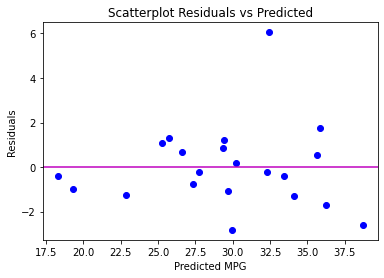

In [22]:
#plot for y_hat vs residuals
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(y_pred, residuals, c='b')
ax.axhline(0, c='m')


ax.set_xlabel('Predicted MPG')
ax.set_ylabel('Residuals')
plt.title('Scatterplot Residuals vs Predicted')
plt.show()

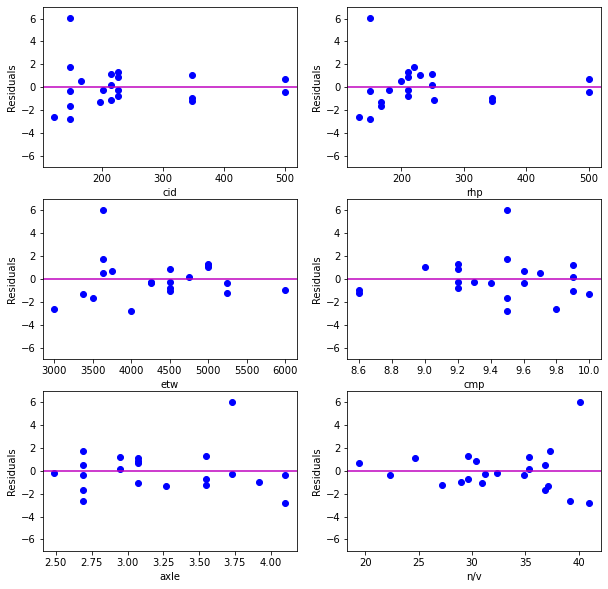

In [23]:
#plots residual vs each regressor
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

for i in range(len(cols_x)):
    var = cols_x[i]
    
    ax[int(i/2)][i%2].scatter(X[var], residuals, c='b')
    ax[int(i/2)][i%2].axhline(0, c='m')

    ax[int(i/2)][i%2].set_ylim([-7,7])
    ax[int(i/2)][i%2].set_xlabel(var)
    ax[int(i/2)][i%2].set_ylabel('Residuals')

##### 3.7 Using α = 0.05, plot the confidence limits and prediction limits for the mean response.

Formula for confidence limits of the mean response:
 $\hat{\mu}_{Y|x_{0}} \pm t_{\alpha/2, n-p} * \sqrt(\hat{\sigma}^{2} x_{0}'(X'X)^{-1}x_{0}) $ 

Formula for prediction limits of the mean response:
 $\hat{\mu}_{Y|x_{0}} \pm t_{\alpha/2, n-p} * \sqrt(\hat{\sigma}^{2}(1+ x_{0}'(X'X)^{-1}x_{0})) $ 

In [24]:
#initiate lists to save the values of the CL and PL

upper_CL = []
lower_CL = []
upper_PL = []
lower_PL = []
Y_response = []

# define significance level
test_alpha = 0.05
# t value is:
t_alpha = stats.t.ppf(1-test_alpha/2, n-p) 


for i in range(n):
    #calculate confidence limits
    u_CL = np.dot(betas,X_std.iloc[i]) + t_alpha*np.sqrt(hat_sigma_2*np.dot(np.dot(np.array(X_std.iloc[i]),C), X_std.iloc[i]))
    l_CL = np.dot(betas,X_std.iloc[i]) - t_alpha*np.sqrt(hat_sigma_2*np.dot(np.dot(np.array(X_std.iloc[i]),C), X_std.iloc[i]))
    
    #calculate prediction limits
    u_PL = np.dot(betas,X_std.iloc[i]) + t_alpha*np.sqrt(hat_sigma_2*(1+np.dot(np.dot(np.array(X_std.iloc[i]),C), X_std.iloc[i])))
    l_PL = np.dot(betas,X_std.iloc[i]) - t_alpha*np.sqrt(hat_sigma_2*(1+np.dot(np.dot(np.array(X_std.iloc[i]),C), X_std.iloc[i])))
   
    y=np.dot(betas,X_std.iloc[i])

    upper_CL.append(u_CL)
    lower_CL.append(l_CL)
    
    upper_PL.append(u_PL)
    lower_PL.append(l_PL)    
    
    Y_response.append(y)
    
print(pd.DataFrame(data= {'Xi':np.arange(n) ,'y_hat':Y_response,'Lower_CL': lower_CL,'Upper_CL': upper_CL, 
                          'Lower_PL': lower_PL,'Upper_PL': upper_PL}))

    Xi      y_hat   Lower_CL   Upper_CL   Lower_PL   Upper_PL
0    0  29.710411  26.718230  32.702593  24.071788  35.349034
1    1  32.270833  29.930287  34.611378  26.949266  37.592400
2    2  34.086592  31.249815  36.923369  28.528875  39.644310
3    3  27.345376  24.843659  29.847092  21.950980  32.739771
4    4  25.727175  23.213599  28.240751  20.327269  31.127081
5    5  22.850158  19.967737  25.732580  17.269005  28.431312
6    6  29.347718  27.705963  30.989473  24.294375  34.401062
7    7  25.291019  21.405799  29.176239  19.131810  31.450228
8    8  29.980694  26.924333  33.037055  24.307752  35.653635
9    9  27.764045  25.429521  30.098570  22.445124  33.082967
10  10  38.692720  36.407772  40.977667  33.395371  43.990069
11  11  30.203493  27.624988  32.781998  24.773059  35.633927
12  12  29.394393  26.431417  32.357369  23.771213  35.017572
13  13  35.844187  33.037350  38.651024  30.301692  41.386682
14  14  18.317895  14.927666  21.708123  12.458324  24.177465
15  15  

### Problem 4

Read data

In [25]:
df = pd.read_csv('Problem set 1 data for problem 4.csv',skiprows=7,usecols =[1,2,3,4,5])

In [26]:
df.head()


,flow,occupancy,speed,speed_down,flow_ratio
0,21,2.7,66.1,65.909191,0.677419
1,15,2.4,66.2,66.598417,0.576923
2,14,2.3,66.1,64.354384,0.560000
3,17,2.5,66.2,64.640938,0.607143
4,15,2.3,66.2,66.139489,0.576923


##### a) Visualize the relationship between every two variables.

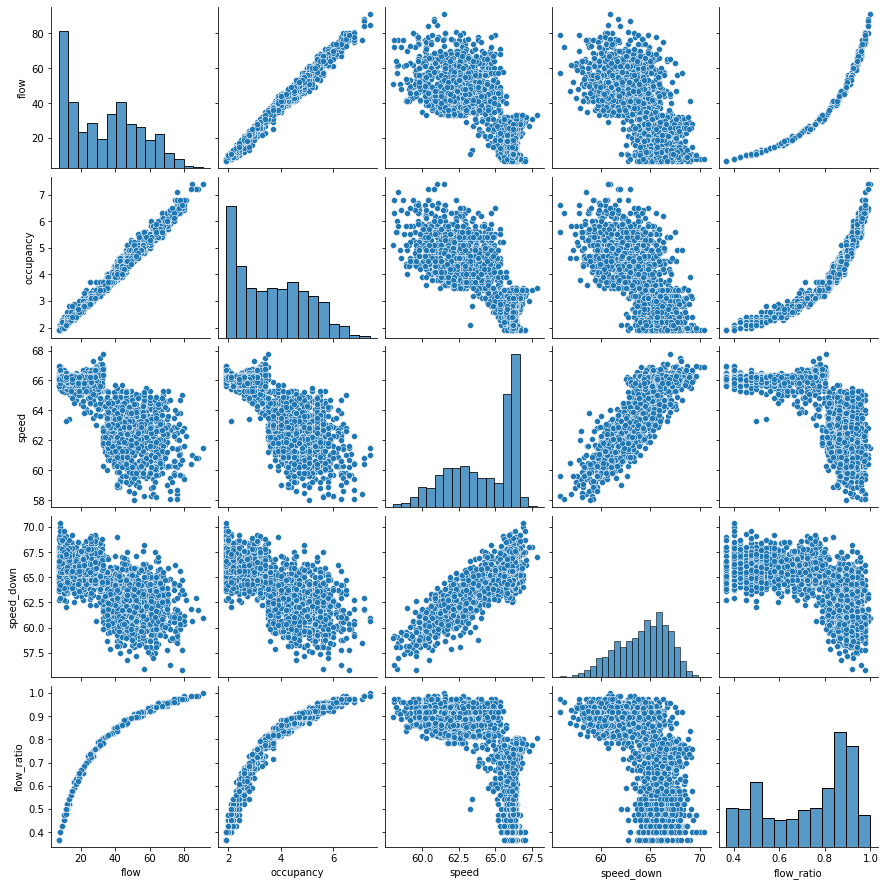

In [27]:
#create scatter plots between each pair or data variables
sns.pairplot(df)

##### b) Fit a multiple linear regression model to the original dataset and evaluate multicollinearity

In [28]:
#first we construct the X and y dataset
cols_x = ['flow','occupancy', 'speed_down', 'flow_ratio']
X = df[cols_x] # the independent
y = df['speed'] # the dependent

In [29]:
# split into training data and test data
#we use the train test split to eliminate the temporal dependancy. We want to predict y independently of 'time'.

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

In [30]:
#define a LinearRegression instance
reg = linear_model.LinearRegression()

#fit the model using the training data
reg.fit(X_train, y_train)

LinearRegression()

Evaluate multicollinearity

$VIF(\beta_{j}) = \frac{1}{1-R_{j}^{2}}$       

$j=1,2,..,k$


In [31]:
# construct a loop to calculate the VIF for every explanatory variable
VIFs = []
RJs = []
for j in range(X.shape[1]):
    y_j = X.iloc[:,j] # x_j
    X_j = X.drop(X.columns[j], axis=1) # the independent set for x_j
    reg_j = linear_model.LinearRegression()
    reg_j.fit(X_j, y_j)
    R_j = reg_j.score(X_j, y_j)
    RJs.append(R_j)
    VIFs.append(1/(1-R_j))


In [32]:
print(pd.DataFrame(data= {'Variable': X.columns,'VIF': VIFs, 'Rj' : RJs}))

     Variable         VIF        Rj
0        flow  104.237266  0.990407
1   occupancy   94.881279  0.989461
2  speed_down    2.096501  0.523015
3  flow_ratio    9.116577  0.890310


##### c) Select suitable regressors for the regression model.

In [33]:
#first we construct the X and y dataset
cols_x = ['flow' ,'speed_down', 'flow_ratio', 'occupancy']
X = df[cols_x] 
y = df['speed'] 

# split into training data and test data
#we use the train test split to eliminate the temporal dependancy. We want to predict y independently of 'time'.

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)


#standardize data. 
#The fit is only done with training data and applied to test data because we dont have the test data in real life
scaler = preprocessing.StandardScaler()
scaler.fit(X_train) 
X_train_std = scaler.transform(X_train) # standardize the original data
X_test_std = scaler.transform(X_test) 


X_train_std = pd.DataFrame(X_train_std)# transform the np.array into pd.DataFrame
X_test_std =  pd.DataFrame(X_test_std)
X_train_std.columns = [str(col) + '_std' for col in X.columns] # change the labels of the columns
X_test_std.columns = [str(col) + '_std' for col in X.columns]

First flow or occupancy needs to be dropped because of the high correlation. To select one, I run a quick regression with each to see which has the highest r2. 

In [34]:
y = y_train.reset_index().drop(['index'], axis =1)
X = X_train_std['flow_std']
#Fit a model for our target and our selected column 
model = sm.OLS(y, sm.add_constant(X)).fit()
display(model.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     2277.
Date:                Tue, 21 Jun 2022   Prob (F-statistic):          1.40e-299
Time:                        15:14:16   Log-Likelihood:                -2508.0
No. Observations:                1452   AIC:                             5020.
Df Residuals:                    1450   BIC:                             5031.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.1410      0.036   1794.399      0.000      64.071      64.211
flow_std      -1.7059      0.036    -47.723      0.000      -1.776      -1.636
==============================================================================
Omnibus:                       34.383   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.630
Skew:                          -0.264   Prob(JB):                     7.49e-11
Kurtosis:                       3.701   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
y = y_train.reset_index().drop(['index'], axis =1)
X = X_train_std['occupancy_std']
#Fit a model for our target and our selected column 
model = sm.OLS(y, sm.add_constant(X)).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     2709.
Date:                Tue, 21 Jun 2022   Prob (F-statistic):               0.00
Time:                        15:14:16   Log-Likelihood:                -2428.4
No. Observations:                1452   AIC:                             4861.
Df Residuals:                    1450   BIC:                             4871.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            64.1410      0.034   1895.475      0.000      64.075      64.207
occupancy_std    -1.7613      0.034    -52.050      0.000      -1.828      -1.695
==============================================================================
Omnibus:                       33.146   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.777
Skew:                          -0.258   Prob(JB):                     1.89e-10
Kurtosis:                       3.689   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Because occupancy has a better Rsquared we drop flow.
From the pair plots, we can see that speed_down and occupancy have an approximate linear relationship with speed. However, flow_ratio does not have a linear relationship with speed, so we try some transformations on this variable.

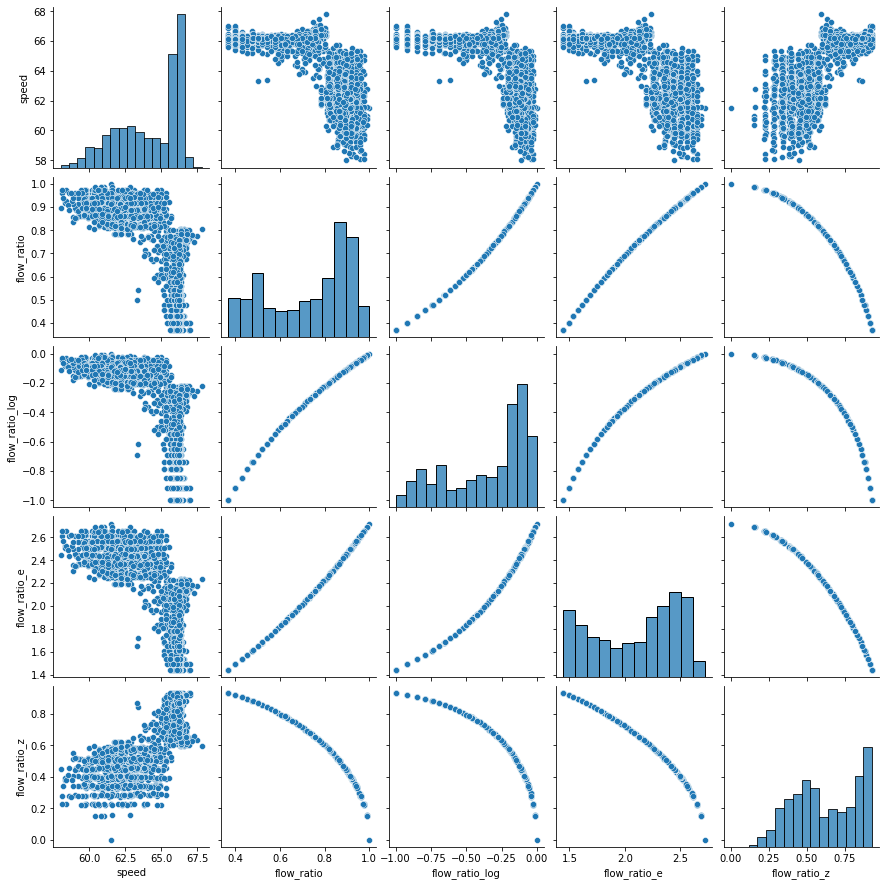

In [36]:
# transformation of flow_ratio

df['flow_ratio_log'] = np.log(df['flow_ratio'])
df['flow_ratio_e'] = np.exp(df['flow_ratio'])
df['flow_ratio_z'] = np.sqrt(1-df['flow_ratio']**2)

sns.pairplot(df[['speed', 'flow_ratio','flow_ratio_log', 'flow_ratio_e','flow_ratio_z']])

The $\sqrt{1-y^{2}}$  (flow_ratio_z) seems to be the best transformation. I check with a regression the R2 each would give as a single regressor.

In [37]:
X = df['flow_ratio'] 
y = df['speed'] 
#Fit a model for our target and our selected column 
model = sm.OLS(y, sm.add_constant(X)).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     2368.
Date:                Tue, 21 Jun 2022   Prob (F-statistic):               0.00
Time:                        15:14:29   Log-Likelihood:                -3233.8
No. Observations:                1816   AIC:                             6472.
Df Residuals:                    1814   BIC:                             6483.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         70.5623      0.136    519.020      0.000      70.296      70.829
flow_ratio    -8.7840      0.181    -48.662      0.000      -9.138      -8.430
==============================================================================
Omnibus:                        6.906   Durbin-Watson:                   0.585
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                6.991
Skew:                          -0.146   Prob(JB):                       0.0303
Kurtosis:                       2.918   Cond. No.                         8.27
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
X = df['flow_ratio_z'] 
y = df['speed'] 
#Fit a model for our target and our selected column 
model = sm.OLS(y, sm.add_constant(X)).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     2848.
Date:                Tue, 21 Jun 2022   Prob (F-statistic):               0.00
Time:                        15:14:29   Log-Likelihood:                -3135.1
No. Observations:                1816   AIC:                             6274.
Df Residuals:                    1814   BIC:                             6285.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           58.9903      0.102    579.017      0.000      58.790      59.190
flow_ratio_z     8.2648      0.155     53.366      0.000       7.961       8.569
==============================================================================
Omnibus:                       23.212   Durbin-Watson:                   0.656
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.516
Skew:                          -0.216   Prob(JB):                     1.75e-06
Kurtosis:                       3.406   Cond. No.                         6.80
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Because flow_ratio_z has a higher r2, I replace flow_ratio for flow_ratio_z. Once this is done I create three new variables, each variable squared, to see if the addition of these variables help the regression. Using the Extra Sum of squares method we determine if at least one of the new variables contributes significantly to the model


The null and alternative hypotheses are:

$H_{0}: \beta_{4} = \beta_{5} =\beta_{6} =0  $

$H_{1}:$ $\beta_{4}\neq 0$ or $\beta_{5}\neq 0$ or $\beta_{6}\neq 0$

T0 test this we need the extra Sum of Squares due to $\beta_{4}$, $\beta_{5}$, and $\beta_{6}$.

$SS_{R}(\beta_{6},\beta_{5},\beta_{4}|\beta_{3},\beta_{2},\beta_{1}, \beta_{0}) = SS_{R}(\beta_{6},\beta_{5},\beta_{4},\beta_{3},\beta_{2},\beta_{1}, \beta{0})- SS_{R}(\beta_{3},\beta_{2},\beta_{1}, \beta{0})$ 

$F_{0} = \frac{SS_{R}(\beta_{6},\beta_{5},\beta_{4}|\beta_{3},\beta_{2},\beta_{1}, \beta_{0})/2}{MS_{E}}$


In [39]:
#first we construct the X and y dataset
cols_x = ['speed_down', 'flow_ratio_z', 'occupancy']
X = df[cols_x] 
y = df['speed'] 

# split into training data and test data
#we use the train test split to eliminate the temporal dependancy. We want to predict y independently of 'time'.

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)


reg.fit(X_train, y_train) # fit a new model


LinearRegression()

In [40]:
#define:
# number of observations
n = len(X_train) 

In [41]:

X_train2 = X_train.copy() # define a copy of X_train as we need to do a comparison below

X_train2['flow_ratio_z_2'] = X_train2['flow_ratio_z']**2
X_train2['occupancy_2'] =    X_train2['occupancy']**2
X_train2['speed_down_2'] =   X_train2['speed_down']**2

reg2 = linear_model.LinearRegression() # define a new LR instance
reg2.fit(X_train2, y_train) # fit a new model


LinearRegression()

In [42]:

X_train.insert(loc=0, column='constant', value=1)
betas1 = [reg.intercept_] + list(reg.coef_)
SSR_beta1 = np.dot(np.array(betas1).T, X_train.T)
SSR_beta1 = np.dot(SSR_beta1, y_train)
SSR_beta1 = SSR_beta1 - (y_train.sum())**2/n
SSR_beta1

5743.027505976148

In [43]:
X_train2.insert(loc=0, column='constant', value=1)
betas2 = [reg2.intercept_] + list(reg2.coef_)
SSR_beta2 = np.dot(np.array(betas2).T, X_train2.T)
SSR_beta2 = np.dot(SSR_beta2, y_train)
SSR_beta2 = SSR_beta2 - (y_train.sum())**2/n
SSR_beta2

5924.065708339214

In [44]:
MSE = np.dot(y_train.T, y_train) - np.dot(np.dot(np.array(betas2).T, X_train2.T), y_train)
MSE = MSE/(n-X_train2.shape[1])
f0 = ((SSR_beta2-SSR_beta1)/2)/MSE
f0

131.9552236497932

We compare  $F_{0}$ to $f_{\alpha, r, n-p}$

$\alpha =0.05$

$n-p = 1452-7 = 1445 $

$r = 3$

From the table:

$f_{0.05, 3, 120} = 2.6802$
 
 $f_{0.05, 3, \infty} = 2.6049$
 
Which is why we conclude that at least one of the new variables contributes significantly to the 
model, and we reject the null hypothesis.

Using stepwise regression we choose which regressors to keep

In [45]:
#construct data set

cols_x = ['speed_down', 'occupancy', 'flow_ratio_z']
X = df[cols_x] 
y = df['speed'] 


X['flow_ratio_z_2'] = X['flow_ratio_z']**2
X['occupancy_2'] =    X['occupancy']**2
X['speed_down_2'] =   X['speed_down']**2

# split into training data and test data
#we use the train test split to eliminate the temporal dependancy. We want to predict y independently of 'time'.

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)


#standardize data. 
#The fit is only done with training data and applied to test data because we dont have the test data in real life
scaler = preprocessing.StandardScaler()
scaler.fit(X_train) 
X_train_std = scaler.transform(X_train) # standardize the original data
X_test_std = scaler.transform(X_test) 


X_train_std = pd.DataFrame(X_train_std)# transform the np.array into pd.DataFrame
X_test_std =  pd.DataFrame(X_test_std)
X_train_std.columns = [str(col) + '_std' for col in X.columns] # change the labels of the columns
X_test_std.columns = [str(col) + '_std' for col in X.columns]

In [46]:
y = y_train.reset_index().drop(['index'], axis =1)
X = X_train_std
#Create an empty dictionary that will be used to store our results
function_dict = {'predictor': [], 'r-squared':[]}
#Iterate through every column in X
for col in X.columns:
    #Create a dataframe called selected_X with only the 1 column
    selected_X = X[[col]]
    #Fit a model for our target and our selected column 
    model = sm.OLS(y, sm.add_constant(selected_X)).fit()
    #Predict what our target would be for our model
    y_preds = model.predict(sm.add_constant(selected_X))
    #Add the column name to our dictionary
    function_dict['predictor'].append(col)
    #Calculate the r-squared value between the target and predicted target
    r2 = np.corrcoef(y_train, y_preds)[0, 1]**2
    #Add the r-squared value to our dictionary
    function_dict['r-squared'].append(r2)
    
#Once it's iterated through every column, turn our dictionary into a DataFrame and sort it
function_df = pd.DataFrame(function_dict).sort_values(by=['r-squared'], ascending = False)
#Display only the top 5 predictors
display(function_df.head())

,predictor,r-squared
0,speed_down_std,0.748251
5,speed_down_2_std,0.743198
1,occupancy_std,0.651375
2,flow_ratio_z_std,0.614845
4,occupancy_2_std,0.608199


In [47]:

#function that loops through each column that isn't in your feature model and calculatse the r-squared value if it 
#were the next feature added to the model. 

def next_possible_feature (X_npf, y_npf, current_features, ignore_features=[]):

    #Create an empty dictionary that will be used to store our results
    function_dict = {'predictor': [], 'r-squared':[]}
    #Iterate through every column in X
    for col in X_npf.columns:
        #But only create a model if the feature isn't already selected or ignored
        if col not in (current_features+ignore_features):
            #Create a dataframe called function_X with our current features + 1
            selected_X = X_npf[current_features + [col]]
            #Fit a model for our target and our selected columns 
            model = sm.OLS(y_npf, sm.add_constant(selected_X)).fit()
            #Predict what  our target would be for our selected columns
            y_preds = model.predict(sm.add_constant(selected_X))
            #Add the column name to our dictionary
            function_dict['predictor'].append(col)
            #Calculate the r-squared value between the target and predicted target
            r2 = np.corrcoef(y_train, y_preds)[0, 1]**2
            #Add the r-squared value to our dictionary
            function_dict['r-squared'].append(r2)
    #Once it's iterated through every column, turn our dict into a sorted DataFrame
    function_df = pd.DataFrame(function_dict).sort_values(by=['r-squared'],\
                                                          ascending = False)
    #Display only the top 5 predictors
    display(function_df.head())

In [48]:
#Start with the first predictor, and see all possibilities for our second.
selected_features = ['speed_down_std']
features_to_ignore = []
#Since our function's ignore_features list is already empty, we don't need to 
#include our features_to_ignore list.
next_possible_feature (X_npf=X, y_npf=y, current_features=selected_features)


,predictor,r-squared
0,occupancy_std,0.829823
1,flow_ratio_z_std,0.822298
3,occupancy_2_std,0.820396
2,flow_ratio_z_2_std,0.820373
4,speed_down_2_std,0.761106


In [49]:
#Start with the first predictor, and see all possibilities for our second.
selected_features = ['speed_down_std', 'occupancy_std']
features_to_ignore = []
#Since our function's ignore_features list is already empty, we don't need to 
#include our features_to_ignore list.
next_possible_feature (X_npf=X, y_npf=y, current_features=selected_features)

,predictor,r-squared
3,speed_down_2_std,0.845274
2,occupancy_2_std,0.832217
0,flow_ratio_z_std,0.830480
1,flow_ratio_z_2_std,0.829965


In [50]:
#Start with the first predictor, and see all possibilities for our second.
selected_features = ['speed_down_std', 'occupancy_std', 'speed_down_2_std']
features_to_ignore = []
#Since our function's ignore_features list is already empty, we don't need to 
#include our features_to_ignore list.
next_possible_feature (X_npf=X, y_npf=y, current_features=selected_features)

,predictor,r-squared
2,occupancy_2_std,0.850752
1,flow_ratio_z_2_std,0.846461
0,flow_ratio_z_std,0.845276


We can see that by adding occupancy_std_2 the model doesn't improve much. So we select 'speed_down_std', 'occupancy_std', 'speed_down_std_2' and calculate again to check the P values.

In [51]:
y = y_train.reset_index().drop(['index'], axis =1)
X = X_train_std[['speed_down_std', 'occupancy_std', 'speed_down_2_std']]
#Fit a model for our target and our selected column 
model = sm.OLS(y, sm.add_constant(X)).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     2637.
Date:                Tue, 21 Jun 2022   Prob (F-statistic):               0.00
Time:                        15:14:30   Log-Likelihood:                -1838.6
No. Observations:                1452   AIC:                             3685.
Df Residuals:                    1448   BIC:                             3706.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               64.1410      0.023   2843.253      0.000      64.097      64.185
speed_down_std      12.7404      0.953     13.365      0.000      10.870      14.610
occupancy_std       -0.8823      0.031    -28.066      0.000      -0.944      -0.821
speed_down_2_std   -11.4698      0.954    -12.025      0.000     -13.341      -9.599
==============================================================================
Omnibus:                       45.344   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.390
Skew:                          -0.086   Prob(JB):                     1.76e-24
Kurtosis:                       4.334   Cond. No.                         96.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### d) Apply linear regression, ridge regression, and lasso regression to estimate the relationship between the average speed of the segment and the regressors you selected. 

In [52]:
#y_train = y_train.reset_index().drop(['index'], axis =1)
X_train = X_train_std[['speed_down_std', 'occupancy_std', 'speed_down_2_std']]
X_test = X_test_std[['speed_down_std', 'occupancy_std', 'speed_down_2_std']]
#y_test =y_test.reset_index().drop(['index'], axis =1)

Linear Regression

In [53]:

#define a LinearRegression instance
reg_lr = linear_model.LinearRegression()

#fit the model using the training data
reg_lr.fit(X_train, y_train)

reg_lr.score(X_test, y_test)
print('Independent variables: ', X_train.columns)
print('Coefficients estimated by Linear regression: ', reg_lr.coef_)
print('Intercept estimated: ', reg_lr.intercept_)
print('R2: ', reg_lr.score(X_test, y_test))

Independent variables:  Index(['speed_down_std', 'occupancy_std', 'speed_down_2_std'], dtype='object')
Coefficients estimated by Linear regression:  [ 12.74035358  -0.88228287 -11.46980114]
Intercept estimated:  64.14097796143251
R2:  0.844116666298643


Ridge Regression

The max r2 for this model is: 0.8441166662986517


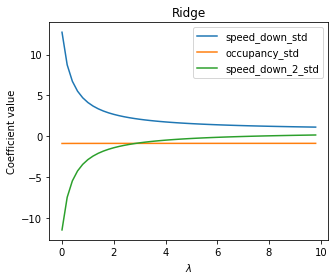

In [54]:
coefs = []
r2=[]
for a in np.arange(0,10,0.2):
     # alpha is the complexity para, i.e., lambda
    reg_ridge = linear_model.Ridge(alpha=a).fit(X_train, y_train)
    coefs.append(reg_ridge.coef_)
    r2.append(reg_ridge.score(X_test, y_test))
    
coefs = pd.DataFrame(coefs)

# the changes of coefficients
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(coefs)
ax.set_xlabel('$\lambda$')

ax.set_xticks(range(0,51,10))
ax.set_xticklabels(range(0,11,2))
ax.set_ylabel('Coefficient value')
ax.legend(X_train.columns)
ax.set_title('Ridge');

print("The max r2 for this model is:", max(r2))

Lasso Regression

The max r2 for this model is: 0.8422804553190684


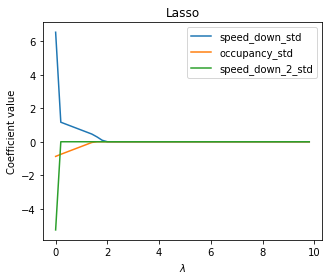

In [55]:
coefs = []
r2=[]
for a in np.arange(0,10,0.2):
     # alpha is the complexity para, i.e., lambda
    reg_lasso = linear_model.Lasso(alpha=a).fit(X_train, y_train)
    coefs.append(reg_lasso.coef_)
    r2.append(reg_lasso.score(X_test, y_test))
    
coefs = pd.DataFrame(coefs)

# the changes of coefficients
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(coefs)
ax.set_xlabel('$\lambda$')

ax.set_xticks(range(0,51,10))
ax.set_xticklabels(range(0,11,2))
ax.set_ylabel('Coefficient value')
ax.legend(X_train.columns)
ax.set_title('Lasso');

print("The max r2 for this model is:", max(r2))